In [2]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import random
from options import DefaultConfig
opt = DefaultConfig()
torch.cuda.set_device(opt.gpu_ids)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed(opt.seed)
torch.cuda.manual_seed_all(opt.seed)
np.random.seed(opt.seed)
random.seed(opt.seed)
import sys
import os
import time
import pdb
from models.model import model
import torch
import torchvision
import torchvision.transforms as transforms
from scipy import interpolate
from utils.image_folder import ImageFolder
from utils import utils
from utils.utils import *
import matplotlib.pyplot as plt
from IPython.display import clear_output


Interaction Network: initialising
Propagation Network: initialising


In [3]:
opt.dataroot = '/home/zhangy23/dataset/vos/'
opt.dataroot_train = opt.dataroot + 'train/'
dataset_train = ImageFolder(opt.dataroot_train, opt.num_frames, 
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.CenterCrop(opt.fineSize),
                                   transforms.ToTensor()]))
dataset_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=opt.batch_size, shuffle=False)
dataset_train_size = len(dataset_train)
print('#training videos = %d' % dataset_train_size)

opt.dataroot_val = opt.dataroot + 'val/'
dataset_val = ImageFolder(opt.dataroot_val, opt.num_frames, 
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.CenterCrop(opt.fineSize),
                                   transforms.ToTensor()]))
dataset_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=opt.batch_size_val, shuffle=False)
dataset_val_size = len(dataset_val)
print('#validation videos = %d' % dataset_val_size)

#training videos = 3305
#validation videos = 486


In [4]:
model = model(opt)
model.setup()

/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.interaction_net.Inet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.interaction_net.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.interaction_net.Decoder' has changed. you can retrieve the original source

[Interaction net] loading Inet sccesses


In [5]:
!nvidia-smi 

Wed Jun 24 09:31:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:19:00.0 Off |                  N/A |
| 42%   73C    P2   119W / 250W |   7866MiB / 11019MiB |     29%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 46%   75C    P2    93W / 250W |   7866MiB / 11019MiB |     31%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2020-06-24 09:31:49


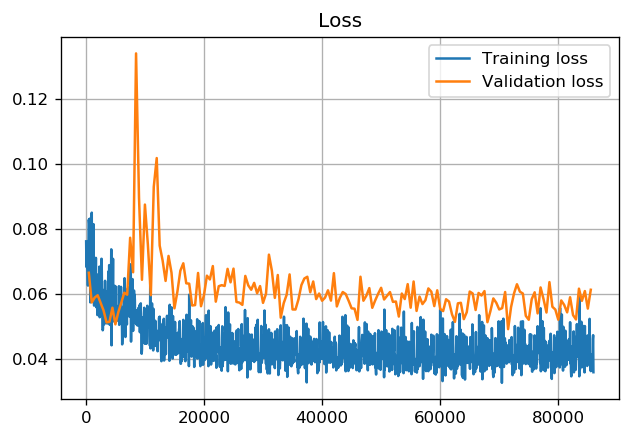

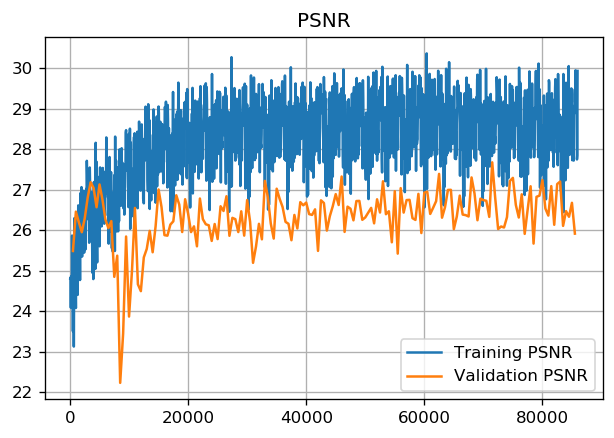

/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


validation phase


KeyboardInterrupt: 

In [7]:
X_val = []
X_train = []

val_losses = []
train_losses = []
val_psnrs = []
train_psnrs = []

total_loss = 0
total_psnr = 0

total_steps = 0
for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay):
    torch.cuda.empty_cache()
    val_step = 0
    model_index = 0
    for i, data_raw in enumerate(dataset_loader_train):
        total_steps += 1
        val_step += 1
        # first round estimation without user interaction, turn on evaluation mode
        opt.no_prev = True
        model.val()
        data_raw0 = torch.squeeze(data_raw[0], dim=0)
        data0 = utils.get_colorization_data(data_raw0, opt)
        data_raw1 = torch.squeeze(data_raw[1], dim=0)
        data1 = utils.get_colorization_data(data_raw1, opt)
        if data0 is None or data1 is None:
            continue
        data = {}
        data['gray'] = data0['gray']
        data['real'] = data0['ab']
        data['prev_t'] = data1['ab']
        data['prev_r'] = data1['prev']
        data = ToCuda(data)
        # data['prev'] = model.run_auto_colour(data)
        # first estimation is used as previous fake_ab, turn on training mode
        model.train()
        opt.no_prev = True
        # random frame index
        # n1, n2 = random.sample(range(1,opt.num_frames), 2)
        fake_ab = model.Pnet(data['gray'], data['prev_r'], data['prev_t'])
        loss = model.Pnet.calc_loss(data['real'], fake_ab)
        model.Pnet.optimizer.zero_grad() 
        loss.backward() 
        model.Pnet.optimizer.step()  
        total_loss += loss.detach().cpu().numpy()
        total_psnr += calc_batch_psnr(data['gray'].detach(), data['real'].detach(), fake_ab.detach(), opt)
        
        if total_steps % opt.val_freq == 0:
            print('validation phase')
            val_loss = 0
            val_psnr = 0
            
            model.val()
            for ii, data_raw_val in enumerate(dataset_loader_val):
                data_cpu_val = {}
                data_raw_val0 = torch.squeeze(data_raw_val[0], dim=0)
                data_val0 = utils.get_colorization_data(data_raw_val0, opt)
                data_raw_val1 = torch.squeeze(data_raw_val[1], dim=0)
                data_val1 = utils.get_colorization_data(data_raw_val1, opt)
                data_cpu_val['gray'] = data_val0['gray']
                data_cpu_val['real'] = data_val0['ab']
                data_cpu_val['prev_t'] = data_val1['ab']
                data_cpu_val['prev_r'] = data_val1['prev']

                opt.no_prev = True
                data_val = ToCuda(data_cpu_val)
                #data_val['prev'] = model.run_auto_colour(data_val)
                
                # update first colourisation
                # n1, n2 = random.sample(range(1,opt.num_frames), 2)
                # fake_ab_val = model.Pnet(data_val['gray'][n1,:,:,:], data_val['prev'][n1,:,:,:], data_val['ab'][n2,:,:,:])
                fake_ab_val = model.Pnet(data_val['gray'], data_val['prev_r'], data_val['prev_t'])
                loss_val = model.Pnet.calc_loss(data_val['real'], fake_ab_val)
                val_loss += loss_val.detach().cpu().numpy()
                val_psnr += calc_batch_psnr(data_val['gray'].detach(), data_val['real'].detach(), fake_ab_val.detach(), opt)
                
            val_psnrs.append(val_psnr / dataset_val_size)
            val_losses.append(val_loss / dataset_val_size)
            X_val.append(total_steps)
            model.train()
            
            # save model
            model_index += 1
            print('save_model')
            save_model(model.Pnet, opt, epoch, model_index, val_psnr / dataset_val_size)
            
        if total_steps % opt.print_freq == 0:
            X_train.append(total_steps)
            # loss and PSNR
            train_psnrs.append(total_psnr / opt.print_freq)
            train_losses.append(total_loss / opt.print_freq)
            total_loss = 0
            total_psnr = 0
            
            # plot loss and PSNR curve
            clear_output(wait=True)
            plt.figure(1)
            plt.rcParams['figure.dpi'] = 120 
            #plt.ylim([0, .08])
            plt.title('Loss')
            plt.plot(X_train, train_losses, label="Training loss")
            plt.plot(X_val, val_losses, label="Validation loss")
            plt.grid(True)
            plt.legend()
            plt.show()

            plt.figure(2)
            plt.rcParams['figure.dpi'] = 120 
            # plt.ylim([15, 30])
            plt.title('PSNR')
            plt.plot(X_train, train_psnrs, label="Training PSNR")
            plt.plot(X_val, val_psnrs, label="Validation PSNR")
            plt.grid(True)
            plt.legend()
            plt.show()
    
    np.save('Iter'+str(epoch)+'train_loss.npy', train_losses)
    np.save('Iter'+str(epoch)+'val_loss.npy', val_losses)
    np.save('Iter'+str(epoch)+'train_psnr.npy', train_psnrs)
    np.save('Iter'+str(epoch)+'val_psnrs.npy', val_psnrs)


In [ ]:
print(data0)

In [15]:
import os
def make_dataset(root):
    videos = []
    for file in os.listdir(root):
        path = os.path.join(root, file)
        if (os.path.isdir(path)):
            videos.append(path)

    return videos


root = '/home/zhangy23/dataset/vos/val/'
videos = make_dataset(root)

for v in videos:
    i = 0
    frames = os.listdir(v)
    for n in range(100):
        nfile = "/%05d.jpg" % (n)
        old_name = v + '/' + nfile
        if os.path.exists(old_name):
            #print('yes')
            new_name = v + '/' + "/%05d.jpg" % i
            os.rename(old_name, new_name)
            i += 1 

25.60804334567233


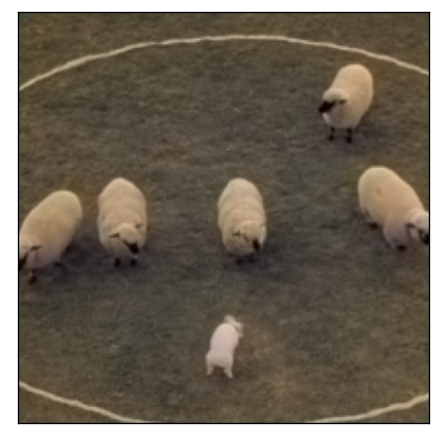

In [15]:
import matplotlib.pyplot as plt 
from skimage.transform import resize
import skimage

lightness = data_val['gray'][4,:,:,:].cpu()
real_ab = data_val['real'][4,:,:,:].cpu()
fake_ab = fake_ab_val[0,:,:,:].cpu()
fake_img = torch.cat((lightness, fake_ab), 0) 
real_img = torch.cat((lightness, real_ab), 0) 

fake_img = fake_img.unsqueeze(0)  # [1, 224, 224, 3]
real_img = real_img.unsqueeze(0)    # [1, 224, 224, 1]

fake_rgb = lab2rgb(fake_img, opt).detach().numpy()
real_rgb = lab2rgb(real_img, opt).detach().numpy()

idx = 0
img = real_rgb[idx,:,:,:].transpose(1,2,0)
img = fake_rgb[idx,:,:,:].transpose(1,2,0)
img = np.minimum(img, 1)
img = resize(img, (1024, 1024))
skimage.io.imshow(img)
plt.xticks([])
plt.yticks([])
mse = np.mean((fake_rgb[idx, :, :, :] - real_rgb[idx, :, :, :]) ** 2 )
psnr = 10 * np.log10(1.0 / mse)
print(psnr)

In [20]:
fake_ab.shape

torch.Size([2, 224, 224])

In [13]:
k1.ndim

4

In [10]:
fake_ab_val.shape

torch.Size([1, 2, 224, 224])